# Logistic Regression on the lab data
We will test in this notebook the efficiency of a logistic regression to classify the different species based on the 3x1m fluorometer.

## Part 1 : The data

Let's open and visualize the data

In [69]:
import pandas as pd 

data = pd.read_csv("/home/flavien/Documents/these/mf/Boussole/Data/labo/results_reshape.csv")

#remove the points where we have no HPLC dat (i.e. the chla_qa is NA)

data_with_hplc = data[data['chla_qa'].notna()]

print(
    f"The original data has "
    f"{len(data)} samples"
    f" and the data with HPLC has "
    f"{len(data_with_hplc)} samples")
data


The original data has 190 samples and the data with HPLC has 66 samples


,strain,replicate,sampling_date,time,chla_conc_spectro,dilution,440nm_max,470nm_max,532nm_max,440nm_mean,...,total_chlorophyll_a,tchla_qa,sum_phaeophytin_a,phytna_qa,a_carotene,a_car_qa,b_carotene,b_car_qa,sum_carotenes,tcar_qa
0,RCC2379,A,2020-10-28T00:00:00Z,1899-12-31T14:45:00Z,49.280000,Cmere,NaN,NaN,NaN,NaN,...,54.1814,1.0,0.0,1.0,0.0,1.0,5.0659,1.0,5.0659,1.0
1,RCC2379,A,2020-10-28T00:00:00Z,1899-12-31T14:45:00Z,27.266000,1,207.0,303.0,158.0,200.642857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RCC2379,A,2020-10-28T00:00:00Z,1899-12-31T15:12:00Z,5.453200,2,186.0,135.0,121.0,179.673611,...,1.0939,1.0,0.0,1.0,0.0,1.0,0.1015,1.0,0.1015,1.0
3,RCC2379,A,2020-10-28T00:00:00Z,1899-12-31T15:43:00Z,1.363300,3,146.0,104.0,298.0,140.435714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RCC2379,A,2020-10-28T00:00:00Z,1899-12-31T16:14:00Z,0.272388,4,440.0,470.0,532.0,110.747292,...,0.1354,1.0,0.0,1.0,0.0,1.0,0.0062,1.0,0.0062,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,RCC1717,C,2020-11-04T00:00:00Z,1899-12-31T12:43:00Z,4.811981,1,751.0,850.0,171.0,727.730061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,RCC1717,C,2020-11-04T00:00:00Z,1899-12-31T12:55:00Z,0.801997,2,213.0,204.0,95.0,204.899225,...,0.9798,1.0,0.0,1.0,0.0,1.0,0.0344,1.0,0.0344,1.0
187,RCC1717,C,2020-11-04T00:00:00Z,1899-12-31T13:08:00Z,0.400998,3,171.0,144.0,81.0,162.771084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,RCC1717,C,2020-11-04T00:00:00Z,1899-12-31T13:18:00Z,0.080040,4,110.0,87.0,75.0,103.815287,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
#select the cols we want
data_sel = data[["440nm_mean", "470nm_mean", "532nm_mean", "strain"]]

#remove the NaN

data_sel = data_sel.dropna()
#rename columns to make it easier to work with
data_sel = data_sel.rename(columns = {"440nm_mean": "f440",
                                    "470nm_mean": "f470",
                                    "532nm_mean": "f532"})

#compute the ratio between each excitation channel
data_sel = data_sel.assign(f440_f470 = lambda x: x['f440']/x['f470'],
                f532_f470 = lambda x: x['f532']/x['f470'],
                f532_f440 = lambda x: x['f532']/x['f440'])




In [71]:
#add common names
def categorise(row):
    if row["strain"] in ["RCC1717", "RCC76", "RCC4213"]:
        return "Diatom"
    elif row["strain"] in ["RCC162", "RCC156", "PCC9511"]:
        return "Prochlorococcus"
    elif row["strain"] in ["RCC2379", "RCC2374", "RCC2319"]:
        return "Synechococcus"
    elif row["strain"] == "RCC100":
        return "Pelagophyte"
    elif row["strain"] == "RCC3006":
        return "Dino" 

data_sel["common_name"] = data_sel.apply(lambda row: categorise(row), axis = 1)

<AxesSubplot:xlabel='f440_f470', ylabel='f532_f470'>

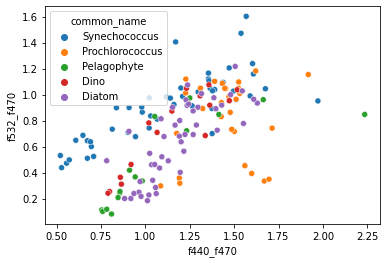

In [72]:
import seaborn as sns

sns.scatterplot(data = data_sel, x = "f440_f470", y = "f532_f470", hue = "common_name")

## Prediction using logistic regression

Let's try to implement a logistic regression here.

In [74]:
#split the dataset
#from sklearn.model_selection import train_test_split

data_sel_minimal = data_sel[["f440_f470", "f532_f470", 'f532_f440']]
target = data_sel["common_name"]


In [76]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="none")
)

In [79]:
groups, _ = pd.factorize(target)

In [81]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

cv = GroupKFold()
test_score = cross_val_score(logistic_regression, data_sel_minimal, target, groups=groups, cv=cv,
                             n_jobs=2, scoring="balanced_accuracy")
print(f"The average accuracy is "
      f"{test_score.mean():.3f} +/- "
      f"{test_score.std():.3f}")

The average accuracy is 0.000 +/- 0.000


In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(classifier, data_test, target_test)

ModuleNotFoundError: No module named 'helpers.plotting'